In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 15})

We will take the Chebyshev differentiation matrix.

In [2]:
def cheb(Ncheb, a, b):
    x = np.cos(np.pi * np.arange(Ncheb + 1) / Ncheb)
    t = 0.5 * (a + b) + 0.5 * (b - a) * x  

    c = np.ones(Ncheb + 1)
    c[0] = c[-1] = 2.
    c = c * (-1)**np.arange(Ncheb + 1)

    X = np.tile(x, (Ncheb + 1, 1)).T
    dX = X - X.T

    D = (c[:, None] / c[None, :]) / (dX + np.eye(Ncheb + 1))
    np.fill_diagonal(D, 0.0)
    D[np.diag_indices_from(D)] = -np.sum(D, axis=1)

    Dcheb = (2.0 / (b - a)) * D

    return Dcheb, t


We specify the initial quantities for the background 

In [3]:
w = 1/3.                        #equation of state parameter
fw = 3*(1+w)/(5+3*w)

dt0 = 10**(-3.)
t0 = 1.                         #initial time
tf = 80000.                     #final time
a0 = 1.                         #initial scale factor
H0 = 2./(3*(1.+w)*t0)             #initial Hubble parameter
rho_b0 = (3*H0**2)/(8*np.pi)       #initial density 
r_H0 = 1/H0                     #initial Hubble radius

The small parameter $\epsilon$ was defined as the ratio between the initial Hubble radius and the lengthscale of the perturbation:

$$\epsilon=\frac{R_H}{ar_m}$$

In [4]:
init_rm_N = 10
r_m = init_rm_N * r_H0
eps = r_H0/(a0*r_m)

Let's create the universe. We want the size to be some $N$ factor greater than the initial Hubble radius.

In [5]:
N_H = 90.
r_init = 0.
r_f = N_H*r_H0

N_cheb = 400                                    # number of collocation points
D_mat, r_vals = cheb(N_cheb, r_init, r_f)       # derivative matrix and collocation points

vector_ones = np.ones(N_cheb+1)                 # vector of ones

Initialize FRW background solutions

In [6]:
def rho_bg(t):
        return vector_ones*rho_b0*(t0/t)**2

def bg_sol(t):
    rho_FRW = rho_bg(t)                    
    wexp = 2./(3.*(1+w))
    a_FRW = a0*(t/t0)**wexp
    adot_FRW = (wexp/t0)*a0*(t/t0)**(wexp-1)
    H_FRW = adot_FRW/a_FRW
    A_FRW = 1.*vector_ones
    B_FRW = r_vals*a_FRW
    R_FRW = r_vals*a_FRW
    U_FRW = r_vals*adot_FRW
    M_FRW = (4.*np.pi*rho_FRW*R_FRW**3)/3.
    G_FRW = 1.*vector_ones
    return a_FRW, H_FRW, A_FRW, B_FRW, R_FRW, U_FRW, M_FRW, G_FRW

The relevant set of differential equations is given by the Misner-sharp equations:

\begin{align*}
\dot{U} &= -A \left[ \frac{w}{1+w} \frac{\Gamma^2}{\rho} \frac{\rho'}{R'} + \frac{M}{R^2} + 4\pi R w \rho \right], \\
\dot{R} &= AU, \\
\dot{\rho} &= -A \rho (1 + w) \left( \frac{2U}{R} + \frac{U'}{R'} \right), \\
\dot{M} &= -4\pi A w \rho U R^2,
\end{align*}

We will solve this using the 4th order Runge-Kutta Method. First, we will define useful intermediate functions that we can tweak later on.

In [7]:
def spatial_dev(R, rho, U):
    R_dev = D_mat @ R
    rho_dev = D_mat @ rho
    U_dev = D_mat @ U

    return R_dev, rho_dev, U_dev

We already know the exact solution for $A$.

In [8]:
def static_sol(R, rho, U, M, rho_FRW):
    
    A = 1.*(rho_FRW/rho)**(w/(w+1.))
    frac_g = M[:-1]/R[:-1]                                  #exclude the final value
    frac_g = np.insert(frac_g, len(frac_g), 0.)              #replace with 0
    Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor
    
    return A, Gamma


The form of ODEs in MSH equations are of the form

$$\frac{\text{d}y}{\text{d}t}=f(A,R,\rho,U,M,R',\rho',U').$$

We will create a function that spits out each $f$ for each ODE in the MSH equations.

In [9]:
def dot_quants(A, R, rho, U, M, R_r, rho_r, U_r, Gamma):

        frac_devUR = U_r/R_r

        frac_UR = U[:-1]/R[:-1]
        frac_UR = np.insert(frac_UR, len(frac_UR), frac_devUR[-1])

        frac_MRsq = M[:-1]/R[:-1]**2
        frac_MRsq = np.insert(frac_MRsq, len(frac_MRsq), 0.)

        U_dot = -A * ( (w / (1. + w)) * (Gamma**2 / rho) * (rho_r / R_r) + frac_MRsq + 4. * np.pi * R * w * rho )
        R_dot = A * U
        rho_dot = -A * rho * (1. + w) * (2. * frac_UR + frac_devUR)
        M_dot = -4. * np.pi * A * w * rho * U * R**2

        return R_dot, rho_dot, U_dot, M_dot 

We will now define a function that packages one Runge-Kutta step of $A, R, \rho, U,$ and $M$.

In [10]:
def rk4_step(A, R, rho, U, M, R_r, rho_r, U_r, Gamma, t, dt):
    
    k1_R, k1_rho, k1_U, k1_M = dot_quants(A, R, rho, U, M, R_r, rho_r, U_r, Gamma)

    R1 = R + 0.5*dt * k1_R
    rho1 = rho + 0.5*dt * k1_rho
    U1 = U + 0.5*dt * k1_U
    M1 = M + 0.5*dt * k1_M

    R1[-1] = 0.
    U1[-1] = 0.
    M1[-1] = 0.

    R_r1, rho_r1, U_r1 = spatial_dev(R1, rho1, U1)
    rho_r1[0] = 0.
    rho_r1[-1] = 0.

    rho_FRW1 = rho_bg(t + 0.5*dt)

    A1, Gamma1 = static_sol(R1, rho1, U1, M1, rho_FRW1)
    k2_R, k2_rho, k2_U, k2_M = dot_quants(A1, R1, rho1, U1, M1, R_r1, rho_r1, U_r1, Gamma1)

    R2 = R + 0.5*dt * k2_R
    rho2 = rho + 0.5*dt * k2_rho
    U2 = U + 0.5*dt * k2_U
    M2 = M + 0.5*dt * k2_M

    R2[-1] = 0.
    U2[-1] = 0.
    M2[-1] = 0.

    R_r2, rho_r2, U_r2 = spatial_dev(R2, rho2, U2)
    rho_r2[0] = 0.
    rho_r2[-1] = 0.

    rho_FRW2 = rho_bg(t + 0.5*dt)

    A2, Gamma2 = static_sol(R2, rho2, U2, M2, rho_FRW2)
    k3_R, k3_rho, k3_U, k3_M = dot_quants(A2, R2, rho2, U2, M2, R_r2, rho_r2, U_r2, Gamma2)

    R3 = R + dt * k3_R
    rho3 = rho + dt * k3_rho
    U3 = U + dt * k3_U
    M3 = M + dt * k3_M

    R3[-1] = 0.
    U3[-1] = 0.
    M3[-1] = 0.

    R_r3, rho_r3, U_r3 = spatial_dev(R3, rho3, U3)
    rho_r3[0] = 0.
    rho_r3[-1] = 0.

    rho_FRW3 = rho_bg(t + dt)
    
    A3, Gamma3 = static_sol(R3, rho3, U3, M3, rho_FRW3)
    k4_R, k4_rho, k4_U, k4_M = dot_quants(A3, R3, rho3, U3, M3, R_r3, rho_r3, U_r3, Gamma3)
    
    R_new = R + dt/6. * (k1_R + 2.*k2_R + 2.*k3_R + k4_R)
    rho_new = rho + dt/6. * (k1_rho + 2.*k2_rho + 2.*k3_rho + k4_rho)
    U_new = U + dt/6. * (k1_U + 2.*k2_U + 2.*k3_U + k4_U)
    M_new = M + dt/6. * (k1_M + 2.*k2_M + 2.*k3_M + k4_M)
    
    return R_new, rho_new, U_new, M_new

If one needs to construct a consistent set of initial conditions for all $r$ and $t$, the MSE must be solved analytically. We do not have this luxury. We need to make a long wavelength approximation and set our initial conditions for large $r$. We must first choose our curvature profile. We initially choose it to be Gaussian.

In [11]:
def K(r, amp):
    return amp*np.exp(-r**2/r_m**2)

def K_prime(r, amp):
    return -2*amp*r*np.exp(-r**2/r_m**2)/(r_m**2)

With this, we generate the initial conditions for long-wavelength solutions.

In [12]:
def init_perturbations(r, amp):

    a_FRW, H_FRW, _, _, _, _, _, _ = bg_sol(t0)

    rho_FRW = rho_bg(t0)
    
    rho_tilde = (3.*(1+w)/(5.+3.*w))*(K(r, amp)+r*K_prime(r, amp)/3.)*r_m**2
    U_tilde = -1. / (5. + 3. * w)* K(r, amp) * r_m**2

    A_tilde = -w / (1. + w)* rho_tilde
    M_tilde = -3. * (1. + w)* U_tilde
    R_tilde = -w / ((1. + 3. * w) * (1 + w)) * rho_tilde + 1. / (1. + 3. * w) * U_tilde


    A_full = 1. + eps**2 * A_tilde
    R_full = a_FRW * r * (1. + (eps**2) * R_tilde)
    rho_full = rho_FRW * (1.+(eps**2)*rho_tilde)
    U_full = H_FRW * R_full * (1. + (eps**2) * U_tilde)
    M_full = (4.*np.pi/3.) * rho_FRW * R_full**3 * (1. + (eps**2) * M_tilde)

    frac_MR = M_full[:-1] / R_full[:-1]
    frac_MR = np.insert(frac_MR, len(frac_MR), 0.)  #replace with 0

    G_full = np.sqrt(1.*vector_ones + U_full**2 - 2.*frac_MR)  

    return A_full, R_full, rho_full, U_full, M_full, G_full

Now we want to evolve our system. 

In [13]:
def computation(A, R, rho, U, M, G, t, dt):
    
    rho_FRW = rho_bg(t)

    Ai = A.copy()
    Ri = R.copy()
    rhoi = rho.copy()
    Ui = U.copy()
    Mi = M.copy()
    Gi = G.copy()   

    Ri_r, rhoi_r, Ui_r = spatial_dev(Ri, rhoi, Ui)
    rhoi_r[0] = 0.
    rhoi_r[-1] = 0.

    R, rho, U, M = rk4_step(Ai, Ri, rhoi, Ui, Mi, Ri_r, rhoi_r, Ui_r, Gi, t, dt)

    R[-1] = 0.
    U[-1] = 0.
    M[-1] = 0.

    A, G = static_sol(R, rho, U, M, rho_FRW)

    return A, R, rho, U, M, G, rho_FRW
    

In [15]:
def evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf):
    
    A_store = []
    R_store = []
    rho_store = []
    U_store = []
    M_store = []
    G_store = []
    t_store = []

    A = A_init
    R = R_init
    rho = rho_init
    U = U_init
    M = M_init
    G = G_init

    A_store.append(A)
    R_store.append(R)
    rho_store.append(rho)
    U_store.append(U)
    M_store.append(M)
    G_store.append(G)
    t_store.append(t0)

    t = t0
    t_H = (a0**2)*t0*init_rm_N**2 # horizon crossing time

    while t < tf:

        dt = dt0*np.sqrt(t)
        t+= dt
        t_store.append(t)

        A, R, rho, U, M, G, rho_FRW = computation(A, R, rho, U, M, G, t, dt)

        A_store.append(A)
        R_store.append(R)
        rho_store.append(rho)
        U_store.append(U)
        M_store.append(M)
        G_store.append(G)

        if t > t_H:
            if np.any(np.isnan(A)) or np.any(np.isnan(R)) or np.any(np.isnan(rho)) or np.any(np.isnan(U)) or np.any(np.isnan(M)) or np.any(np.isnan(G)):
                print("NaN encountered in the solution at time {:.4f}".format(t))
                
                break
            
    return A_store, R_store, rho_store, U_store, M_store, G_store, t_store
        

C:\Users\PC\AppData\Local\Temp/ipykernel_8944/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor
C:\Users\PC\AppData\Local\Temp/ipykernel_8944/3414178278.py:9: RuntimeWarning: invalid value encountered in divide
  AH.append(2*M_hist[i]/R_hist[i])


NaN encountered in the solution at time 4974.1192


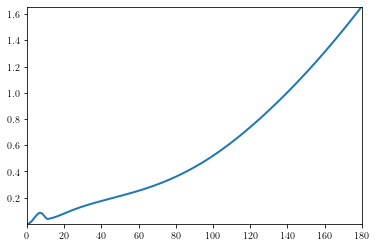

In [15]:
dens_cont = 0.4976733
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

AH = []

for i in range(len(t_hist)):
    AH.append(2*M_hist[i]/R_hist[i])

sec_anim = 5
frames = int(5*24)
AH_anim = []
for i in range(frames):
    AH_anim.append(AH[int(np.floor(len(AH)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = AH_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(AH_anim),
                    init_func=init, blit=True)

ani.save('figures//AH_anim_0_4976733.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_8944/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 4693.4753


C:\Users\PC\AppData\Local\Temp/ipykernel_8944/467448601.py:9: RuntimeWarning: invalid value encountered in divide
  AH.append(2*M_hist[i]/R_hist[i])


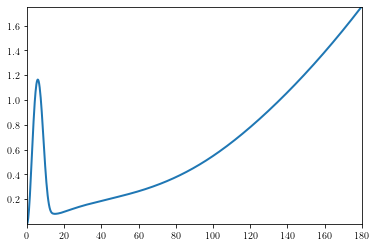

In [ ]:
dens_cont = 0.49777
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

AH = []

for i in range(len(t_hist)):
    AH.append(2*M_hist[i]/R_hist[i])

sec_anim = 5
frames = int(5*24)
AH_anim = []
for i in range(frames):
    AH_anim.append(AH[int(np.floor(len(AH)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = AH_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(AH_anim),
                    init_func=init, blit=True)

ani.save('figures//AH_anim_0_49777.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_8944/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 4974.1192


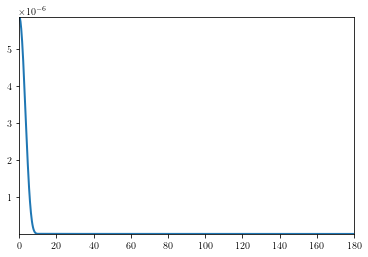

In [22]:
dens_cont = 0.4976733
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

sec_anim = 5
frames = int(5*24)
rho_anim = []
for i in range(frames):
    rho_anim.append(rho_hist[int(np.floor(len(rho_hist)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('figures//rho_anim_0_4976733.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_4736/427123059.py:3: RuntimeWarning: invalid value encountered in power
  A = 1.*(rho_FRW/rho)**(w/(w+1.))


NaN encountered in the solution at time 5028.2897


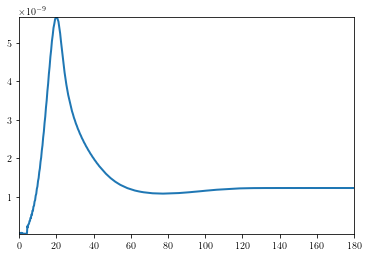

In [15]:
dens_cont = 0.497
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

sec_anim = 5
frames = int(5*24)
rho_anim = []
for i in range(frames):
    rho_anim.append(rho_hist[int(np.floor(len(rho_hist)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('figures//rho_anim_0_497.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_4736/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 3980.7221


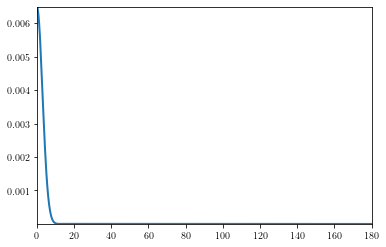

In [16]:
dens_cont = 0.498
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

sec_anim = 5
frames = int(5*24)
rho_anim = []
for i in range(frames):
    rho_anim.append(rho_hist[int(np.floor(len(rho_hist)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('figures//rho_anim_0_498.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_8944/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 4693.4753


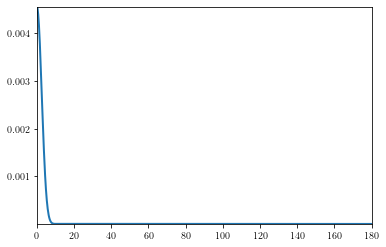

In [23]:
dens_cont = 0.49777
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

sec_anim = 5
frames = int(5*24)
rho_anim = []
for i in range(frames):
    rho_anim.append(rho_hist[int(np.floor(len(rho_hist)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('figures//rho_anim_0_49777.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_8944/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 4992.0493


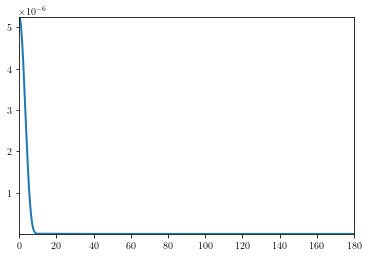

In [ ]:
dens_cont = 0.4976735
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

sec_anim = 5
frames = int(5*24)
rho_anim = []
for i in range(frames):
    rho_anim.append(rho_hist[int(np.floor(len(rho_hist)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('figures//rho_anim_0_4976735.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_17816/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 4529.1484


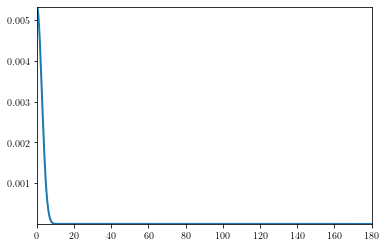

In [17]:
dens_cont = 0.4977951
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

sec_anim = 5
frames = int(5*24)
rho_anim = []
for i in range(frames):
    rho_anim.append(rho_hist[int(np.floor(len(rho_hist)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('figures//rho_anim_0_4977951.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_17816/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 4529.1484


C:\Users\PC\AppData\Local\Temp/ipykernel_17816/124976103.py:14: RuntimeWarning: invalid value encountered in divide
  comp_func.append(2*(M_hist[i]-Mbg_hist[i])/R_hist[i])


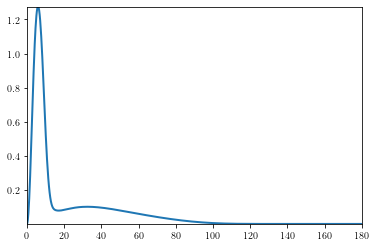

In [18]:
dens_cont = 0.4977951
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

Mbg_hist = []
for t in t_hist:
    _, _, _, _, _, _, Mbg, _ = bg_sol(t)
    Mbg_hist.append(Mbg)

comp_func = []

for i in range(len(t_hist)):
    comp_func.append(2*(M_hist[i]-Mbg_hist[i])/R_hist[i])

sec_anim = 5
frames = int(5*24)
AH_anim = []
for i in range(frames):
    AH_anim.append(comp_func[int(np.floor(len(comp_func)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = AH_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(AH_anim),
                    init_func=init, blit=True)

ani.save('figures//comp_func_anim_0_4977951.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_17816/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 4530.2252


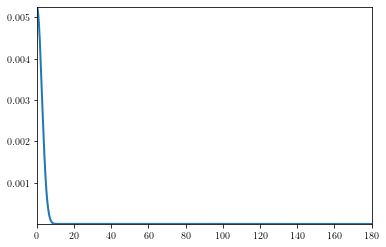

In [16]:
dens_cont = 0.4977949
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

sec_anim = 5
frames = int(5*24)
rho_anim = []
for i in range(frames):
    rho_anim.append(rho_hist[int(np.floor(len(rho_hist)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('figures//rho_anim_0_4977949.mp4', fps=24, dpi=150, writer='ffmpeg')

In [ ]:
dens_cont = 0.4977949
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

sec_anim = 5
frames = int(5*24)
rho_anim = []
for i in range(frames):
    rho_anim.append(rho_hist[int(np.floor(len(rho_hist)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('figures//rho_anim_0_4977949.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_17816/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 4530.2252


C:\Users\PC\AppData\Local\Temp/ipykernel_17816/2182671986.py:14: RuntimeWarning: invalid value encountered in divide
  comp_func.append(2*(M_hist[i]-Mbg_hist[i])/R_hist[i])


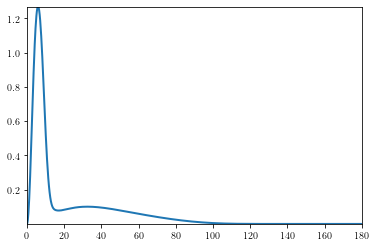

In [19]:
dens_cont = 0.4977949
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

Mbg_hist = []
for t in t_hist:
    _, _, _, _, _, _, Mbg, _ = bg_sol(t)
    Mbg_hist.append(Mbg)

comp_func = []

for i in range(len(t_hist)):
    comp_func.append(2*(M_hist[i]-Mbg_hist[i])/R_hist[i])

sec_anim = 5
frames = int(5*24)
AH_anim = []
for i in range(frames):
    AH_anim.append(comp_func[int(np.floor(len(comp_func)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = AH_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(AH_anim),
                    init_func=init, blit=True)

ani.save('figures//comp_func_anim_0_4977949.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_17816/427123059.py:3: RuntimeWarning: invalid value encountered in power
  A = 1.*(rho_FRW/rho)**(w/(w+1.))


NaN encountered in the solution at time 12211.5371


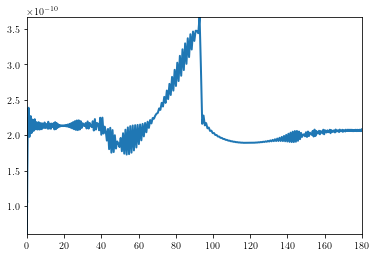

In [20]:
dens_cont =  0.49264174291069773
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

sec_anim = 5
frames = int(5*24)
rho_anim = []
for i in range(frames):
    rho_anim.append(rho_hist[int(np.floor(len(rho_hist)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('figures//rho_anim_0_49264174291069773.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_17816/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 2852.5753


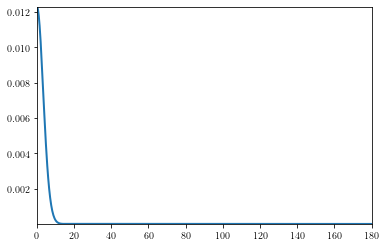

In [21]:
dens_cont =  0.5005519667177872
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

sec_anim = 5
frames = int(5*24)
rho_anim = []
for i in range(frames):
    rho_anim.append(rho_hist[int(np.floor(len(rho_hist)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('figures//rho_anim_0_5005519667177872.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_8944/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 4974.1192


C:\Users\PC\AppData\Local\Temp/ipykernel_8944/3865461409.py:14: RuntimeWarning: invalid value encountered in divide
  comp_func.append(2*(M_hist[i]-Mbg_hist[i])/R_hist[i])


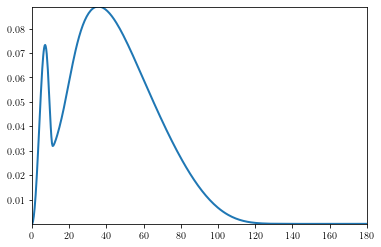

In [ ]:
dens_cont = 0.4976733
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

Mbg_hist = []
for t in t_hist:
    _, _, _, _, _, _, Mbg, _ = bg_sol(t)
    Mbg_hist.append(Mbg)

comp_func = []

for i in range(len(t_hist)):
    comp_func.append(2*(M_hist[i]-Mbg_hist[i])/R_hist[i])

sec_anim = 5
frames = int(5*24)
AH_anim = []
for i in range(frames):
    AH_anim.append(comp_func[int(np.floor(len(comp_func)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = AH_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(AH_anim),
                    init_func=init, blit=True)

ani.save('figures//comp_func_anim_0_4976733.mp4', fps=24, dpi=150, writer='ffmpeg')

C:\Users\PC\AppData\Local\Temp/ipykernel_8944/427123059.py:6: RuntimeWarning: invalid value encountered in sqrt
  Gamma = np.sqrt(1 + U**2 - 2.*frac_g)          #gamma factor


NaN encountered in the solution at time 4693.4753


C:\Users\PC\AppData\Local\Temp/ipykernel_8944/972041131.py:14: RuntimeWarning: invalid value encountered in divide
  comp_func.append(2*(M_hist[i]-Mbg_hist[i])/R_hist[i])


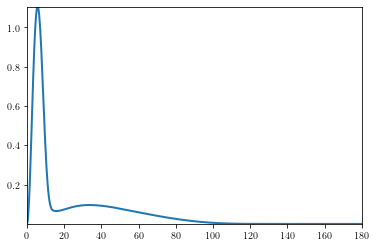

In [28]:
dens_cont = 0.49777
amp_val = dens_cont/((r_m**2)*fw*K(r_m, 1))
A_init, R_init, rho_init, U_init, M_init, G_init = init_perturbations(r_vals, amp_val)
A_hist, R_hist, rho_hist, U_hist, M_hist, G_hist, t_hist = evolve_system(A_init, R_init, rho_init, U_init, M_init, G_init, t0, tf)

Mbg_hist = []
for t in t_hist:
    _, _, _, _, _, _, Mbg, _ = bg_sol(t)
    Mbg_hist.append(Mbg)

comp_func = []

for i in range(len(t_hist)):
    comp_func.append(2*(M_hist[i]-Mbg_hist[i])/R_hist[i])

sec_anim = 5
frames = int(5*24)
AH_anim = []
for i in range(frames):
    AH_anim.append(comp_func[int(np.floor(len(comp_func)/frames))*i])

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = AH_anim[frame]
    y_lim = [y[i] for i in range(len(y)) if not np.isnan(y[i])]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y_lim), np.max(y_lim)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(AH_anim),
                    init_func=init, blit=True)

ani.save('figures//comp_func_anim_0_49777.mp4', fps=24, dpi=150, writer='ffmpeg')

In [29]:
"""
Animation template


fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(np.min(r_vals), np.max(r_vals))

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = rho_hist[frame]
    line.set_data(r_vals, y)
    ax.set_ylim(np.min(y), np.max(y)) 
    return line,

ani = FuncAnimation(fig, update, frames=len(rho_anim),
                    init_func=init, blit=True)

ani.save('//figures//rho_hist_animation.mp4', fps=24, dpi=150, writer='ffmpeg')
"""

"\nAnimation template\n\n\nfig, ax = plt.subplots()\nline, = ax.plot([], [], lw=2)\nax.set_xlim(np.min(r_vals), np.max(r_vals))\n\ndef init():\n    line.set_data([], [])\n    return line,\n\ndef update(frame):\n    y = rho_hist[frame]\n    line.set_data(r_vals, y)\n    ax.set_ylim(np.min(y), np.max(y)) \n    return line,\n\nani = FuncAnimation(fig, update, frames=len(rho_anim),\n                    init_func=init, blit=True)\n\nani.save('//figures//rho_hist_animation.mp4', fps=24, dpi=150, writer='ffmpeg')\n"